# ML Final Project

### Tanay, Vishal, Nikshita, Garv

## About the Dataset

Link to the dataset: [Link](https://www.kaggle.com/competitions/spaceship-titanic/overview)

The machine learning problem that we are trying to solve is to predict whether a passenger aboard the Spaceship Titanic was transported to an alternate dimension during its collision with a spacetime anomaly. This is a binary classification problem as the target variable "Transported" indicates True or False. This problem matters because an accurate model will help space agents quickly locate which passengers are missing from the spaceship and start looking for them quickly (before they run out of oxygen). 

### Description of the Dataset and Attributes
`PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

`HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

`CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

`Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

`Destination` - The planet the passenger will be debarking to.

`Age` - The age of the passenger.

`VIP` - Whether the passenger has paid for special VIP service during the voyage.

`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

`Name` - The first and last names of the passenger.

`Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
# !pip install scikit-learn matplotlib numpy pandas tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 
from pandas import DataFrame
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

df = pd.read_csv("train.csv")

# Data Exploration

In [3]:
# Checking how many NaNs there are 
rows_with_nan = df.isnull().any(axis=1).sum()
rows_without_nan = len(df) - rows_with_nan

print(f"Rows with NaN: {rows_with_nan}")
print(f"Rows without NaN: {rows_without_nan}")

print("Columns with NaNs: ", df.isnull().any())

# Checking what the data looks like
print()
print("We can see what the data looks like for the first 5 rows.")
df.head()

Rows with NaN: 2087
Rows without NaN: 6606
Columns with NaNs:  PassengerId     False
HomePlanet       True
CryoSleep        True
Cabin            True
Destination      True
Age              True
VIP              True
RoomService      True
FoodCourt        True
ShoppingMall     True
Spa              True
VRDeck           True
Name             True
Transported     False
dtype: bool

We can see what the data looks like for the first 5 rows.


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


These columns had some sort of missing data. Because of that, we're plotting the distributions of the variables 
to see if we should impute the mean or median.


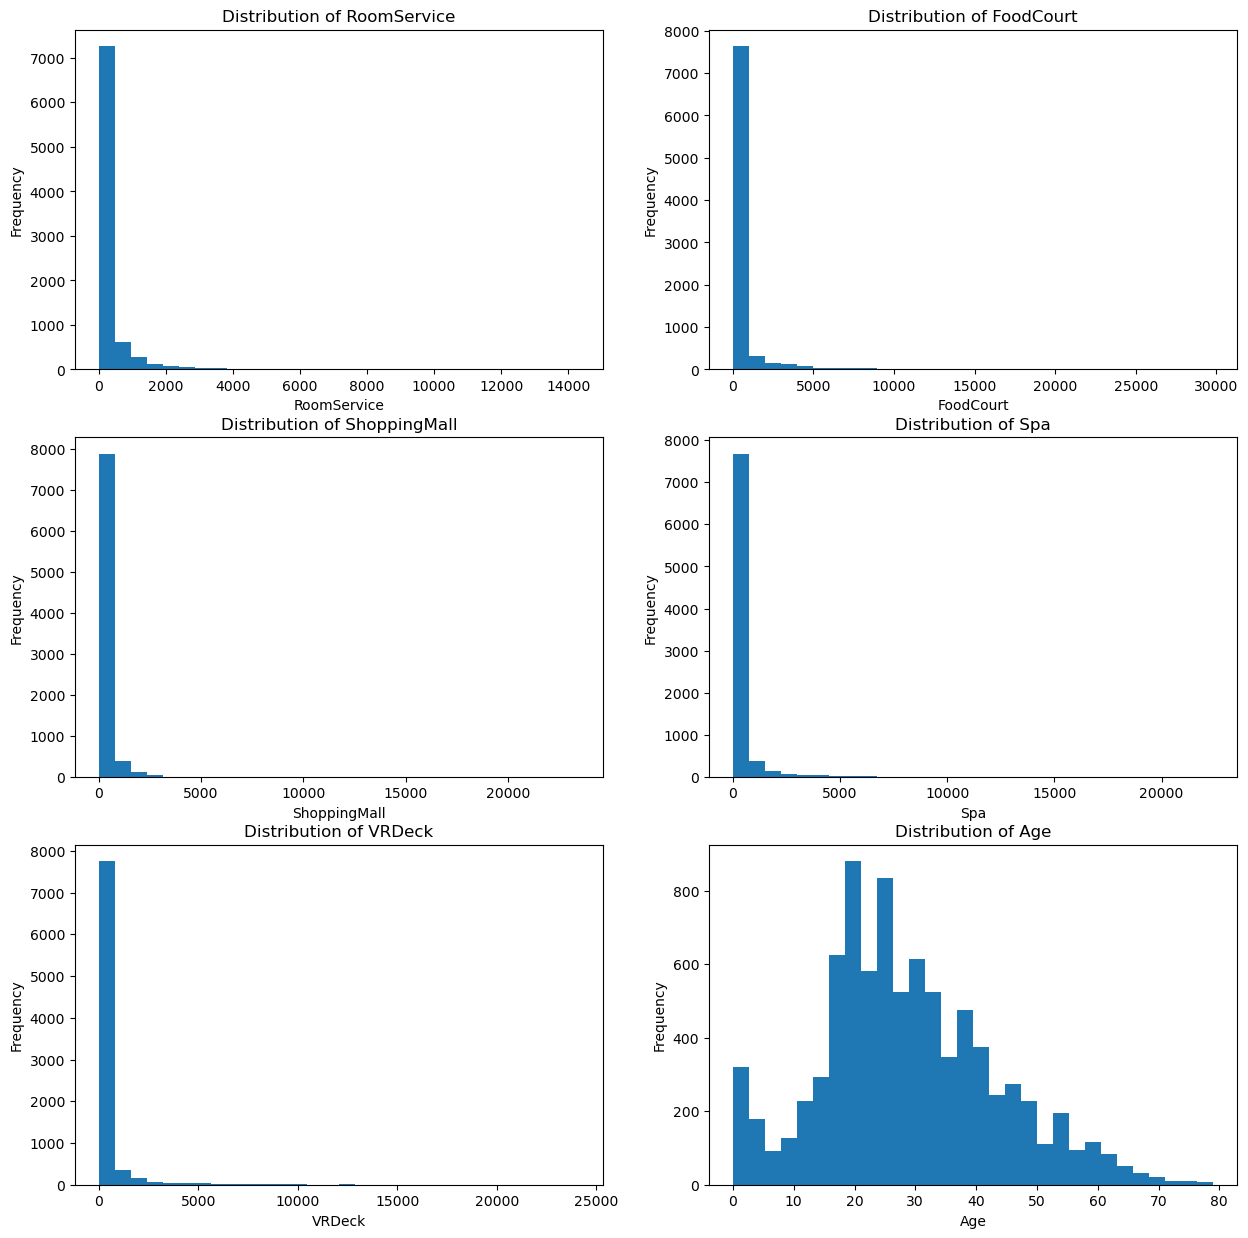

Through these graphs, we see that a lot of the distributions are right-skewed. Since there are a lot of outliers, 
we will impute the median for these variables as that will tend to be more robust to outliers.


In [4]:
# This is to see the distributions of the variables we want to impute (mean or median)
print("These columns had some sort of missing data. Because of that, we're plotting the distributions of the variables \nto see if we should impute the mean or median.")
variables = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age']

# Configure subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

# Create histograms for each variable
for i, var in enumerate(variables):
    axes[i].hist(df[var].dropna(), bins=30)
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.show()

print("Through these graphs, we see that a lot of the distributions are right-skewed. Since there are a lot of outliers, \nwe will impute the median for these variables as that will tend to be more robust to outliers.")

# Data Cleaning

Based on the results of our data exploration, we have decided to process the data in the following ways: Initially, we planned on dropping all 2087 records with NaNs, but we later revisited this as the accuracies we were getting from our models was not as high as we thought it could be, and we felt that more data could help with this. Thus, we decided to impute numerical features with the median for the feature, and categorical features with the the value that best fits the probability distribution. "Age" was the only attribute that we imputed with the mean as the graph wasn't as right-skewed, and there is a limited range of what the age could be. Binary attributes were not imputed as we did not want to risk imputing the wrong values as that would drastically change our output.

In [6]:
imputed_df = df.copy()

# number of rows with NaNs
print("Number of rows with NaNs: ", imputed_df.isnull().any(axis=1).sum())

print("Columns with NaNs before imputation: ", imputed_df.columns[imputed_df.isnull().any()].tolist())

# fill NaNs in HomePlanet with random values based on distribution
value_counts = imputed_df['HomePlanet'].value_counts(normalize=True)
imputed_df["HomePlanet"] = imputed_df["HomePlanet"].fillna(imputed_df["HomePlanet"].apply(lambda _: np.random.choice(value_counts.index, p=value_counts.values)))

# fill NaNs in Destination with random values based on distribution
value_counts = imputed_df['Destination'].value_counts(normalize=True)
imputed_df["Destination"] = imputed_df["Destination"].fillna(imputed_df["Destination"].apply(lambda _: np.random.choice(value_counts.index, p=value_counts.values)))

# Impute RoomService with the median
imputed_df["RoomService"] = imputed_df["RoomService"].fillna(imputed_df["RoomService"].median())

# Impute FoodCourt with the median
imputed_df["FoodCourt"] = imputed_df["FoodCourt"].fillna(imputed_df["FoodCourt"].median())

# Impute ShoppingMall with the median
imputed_df["ShoppingMall"] = imputed_df["ShoppingMall"].fillna(imputed_df["ShoppingMall"].median())

# Impute Spa with the median
imputed_df["Spa"] = imputed_df["Spa"].fillna(imputed_df["Spa"].median())

# Impute VRDeck with the median
imputed_df["VRDeck"] = imputed_df["VRDeck"].fillna(imputed_df["VRDeck"].median())

# Impute Age with the mean
imputed_df['Age'] = imputed_df['Age'].fillna(imputed_df['Age'].mean())

# drop NaNs
processed_features = imputed_df.dropna()

# Drop Name values since they're nearly unique for each passenger and not useful for prediction
imputed_df = imputed_df.drop(columns=['Name'])

print("Columns with NaNs after imputation: ", imputed_df.columns[imputed_df.isnull().any()].tolist())
print("Number of rows with NaNs after imputation: ", imputed_df.isnull().any(axis=1).sum())

Number of rows with NaNs:  2087
Columns with NaNs before imputation:  ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']
Columns with NaNs after imputation:  ['CryoSleep', 'Cabin', 'VIP']
Number of rows with NaNs after imputation:  599


Here, we split the Cabin into three separate columns since the Cabin column contained information about the Deck, Room, and Side of the spaceship. We also split PassengerID into different columns to easily analyze the different groups. We also one-hot encoded the HomePlanet, Destination, and Deck. We also normalize our numerical attribtues so that the PCA is more accurate.

In [7]:
processed_df = imputed_df.copy()

# Split Cabin values into three columns
processed_df[["Deck", "Room", "Side"]] = processed_df['Cabin'].str.split("/", expand=True)
processed_df = processed_df.drop(columns=['Cabin'])

# Split Passenger values into two columns
processed_df[["Group", "Passenger_Number"]] = processed_df['PassengerId'].str.split("_", expand=True)
processed_df = processed_df.drop(columns=['PassengerId'])

# One hot encode the HomePlanet
processed_df = pd.get_dummies(processed_df, columns=["HomePlanet"])

# One hot encode the DestinationPlanet
processed_df = pd.get_dummies(processed_df, columns=["Destination"])

# One hot encode the Deck
processed_df = pd.get_dummies(processed_df, columns=["Deck"])

# convert Side to T or F
processed_df["Side"] = processed_df['Side'].map({'P': True, 'S' : False})

# normalizing numeric features
scaler = StandardScaler()
processed_df['RoomService'] = scaler.fit_transform(processed_df[['RoomService']])
processed_df['FoodCourt'] = scaler.fit_transform(processed_df[['FoodCourt']])
processed_df['ShoppingMall'] = scaler.fit_transform(processed_df[['ShoppingMall']])
processed_df['Spa'] = scaler.fit_transform(processed_df[['Spa']])
processed_df['VRDeck'] = scaler.fit_transform(processed_df[['VRDeck']])
processed_df['Age'] = scaler.fit_transform(processed_df[['Age']])
processed_df['Group'] = scaler.fit_transform(processed_df[['Group']])
processed_df['Passenger_Number'] = scaler.fit_transform(processed_df[['Passenger_Number']])

rows_with_nan = processed_df.isnull().any(axis=1).sum()
rows_without_nan = len(processed_df) - rows_with_nan

print(f"Rows with NaN (will be dropped): {rows_with_nan}")
print(f"Rows without NaN: {len(processed_df) - rows_with_nan}")

processed_df = processed_df.dropna()

processed_df.head()

Rows with NaN (will be dropped): 599
Rows without NaN: 8094


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Room,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,False,0.709437,False,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,False,0,...,False,True,False,True,False,False,False,False,False,False
1,False,-0.336717,False,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,True,0,...,False,True,False,False,False,False,False,True,False,False
2,False,2.034566,True,-0.268001,1.959998,-0.283579,5.695623,-0.219796,False,0,...,False,True,True,False,False,False,False,False,False,False
3,False,0.290975,False,-0.333105,0.523010,0.336851,2.687176,-0.092818,False,0,...,False,True,True,False,False,False,False,False,False,False
4,False,-0.894666,False,0.125652,-0.237159,-0.031059,0.231374,-0.261240,True,1,...,False,True,False,False,False,False,False,True,False,False


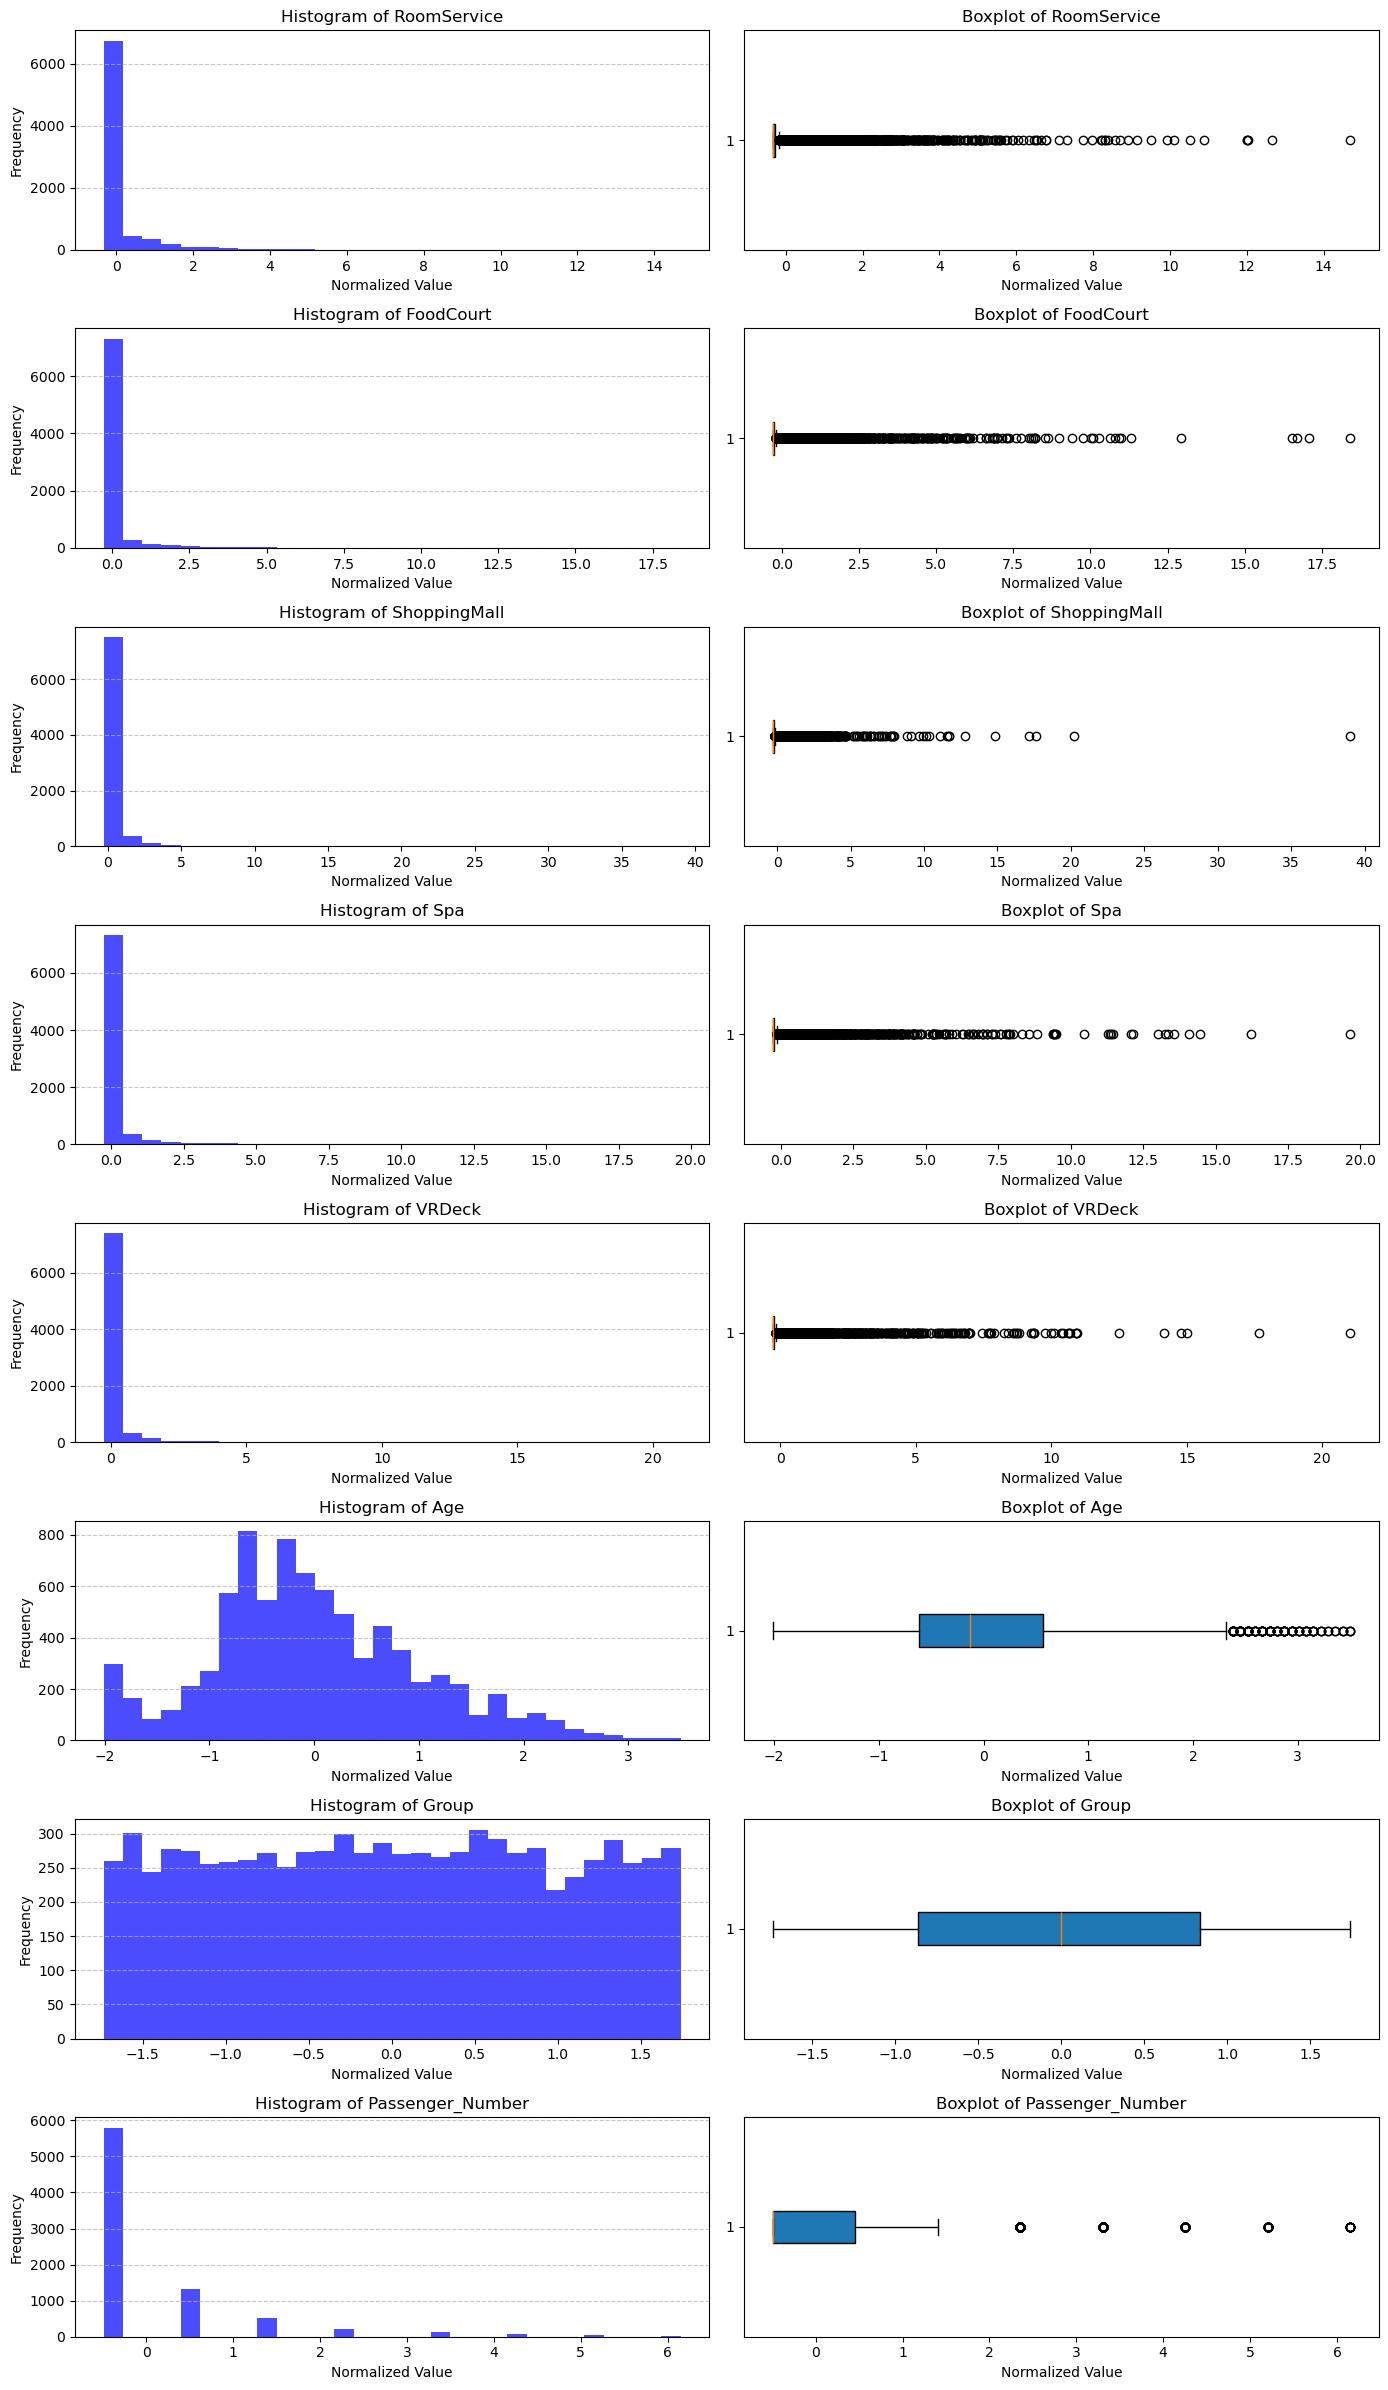

In [8]:
# List of features to plot
features_to_plot = [
    'RoomService', 'FoodCourt', 'ShoppingMall', 
    'Spa', 'VRDeck', 'Age', 
    'Group', 'Passenger_Number'
]

# Create subplots for histograms and boxplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(14, 24))  # 8 rows, 2 columns
axes = axes.flatten()  # Flatten axes for easier iteration

for i, feature in enumerate(features_to_plot):
    axes[2 * i].hist(processed_df[feature], bins=30, color='blue', alpha=0.7)
    axes[2 * i].set_title(f"Histogram of {feature}")
    axes[2 * i].set_xlabel("Normalized Value")
    axes[2 * i].set_ylabel("Frequency")
    axes[2 * i].grid(axis='y', linestyle='--', alpha=0.7)

    axes[2 * i + 1].boxplot(processed_df[feature], vert=False, patch_artist=True)
    axes[2 * i + 1].set_title(f"Boxplot of {feature}")
    axes[2 * i + 1].set_xlabel("Normalized Value")

plt.tight_layout()
plt.show()


Based on these graphs, we can see that these normalized values match the graphs that we have created before. 

Now we're going to actually make our PCA dataframe so that we can pass in these values into our models. PCA helps with dimensionality reduction, making sure that we get rid of the noise in our data. 

In [9]:
labels = processed_df["Transported"]
processed_features = processed_df.drop(labels = "Transported", axis="columns")

pca = PCA(svd_solver='full')
pca_data = pca.fit_transform(processed_features)
pca_df = DataFrame(pca_data)

print("Original data shape:", processed_features.shape)
print("Transformed data shape:", pca_df.shape)
# processed_features.head()
pca_df.shape
pca_df.head()

Original data shape: (8094, 26)
Transformed data shape: (8094, 26)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-599.080833,-0.487112,0.469359,-0.805673,0.172374,-0.179300,-0.326204,-0.115775,0.466152,-0.466662,...,-0.855276,-0.701338,0.014820,-0.166072,-0.025979,0.130106,-0.002498,3.738342e-12,-9.457298e-15,8.558172e-13
1,-599.079415,-0.976504,0.277463,-0.409935,0.254637,-0.209743,0.896551,-0.186799,0.971566,-0.387675,...,0.117539,0.394199,-0.093874,-0.012543,-0.000714,-0.059228,-0.001488,7.594878e-15,-1.359977e-13,-4.399940e-13
2,-599.083469,3.941363,0.163320,-0.662050,-0.405652,-4.127110,1.681266,-0.905459,1.421269,-0.171441,...,-0.152204,-0.278308,0.311571,1.096596,0.842547,0.243530,-0.006866,2.012248e-14,2.790750e-13,5.131272e-13
3,-599.081836,1.210499,-0.218604,0.624558,-0.005555,-1.924774,0.911556,-0.721506,0.878189,-0.365214,...,-0.188369,-0.446157,0.329004,0.978320,-0.125900,0.346610,-0.005067,-9.282515e-14,-2.416236e-14,-9.746455e-14
4,-598.079283,-1.139228,0.301663,-0.020940,0.200283,-0.070614,1.334390,-0.037177,0.822328,-0.364061,...,0.137885,0.393765,-0.085346,-0.006717,0.003872,-0.058155,-0.001362,-4.765291e-13,1.380569e-12,-2.674335e-13


Running PCA gave us the same dimensions as our processed_df because we didn't specify the number of components that we wanted. However, we can still pass this into our models through the pipeline. 

Just to explore the data a little bit more and see if there's any correlations off the top, we're going to run this correlation method. 

[Text(0, 0.5, 'HomePlanet_Europa'),
 Text(0, 1.5, 'HomePlanet_Earth'),
 Text(0, 2.5, 'Room'),
 Text(0, 3.5, 'Deck_G'),
 Text(0, 4.5, 'Deck_F'),
 Text(0, 5.5, 'HomePlanet_Mars'),
 Text(0, 6.5, 'Deck_C'),
 Text(0, 7.5, 'Deck_B'),
 Text(0, 8.5, 'CryoSleep'),
 Text(0, 9.5, 'FoodCourt'),
 Text(0, 10.5, 'Destination_55 Cancri e'),
 Text(0, 11.5, 'Destination_TRAPPIST-1e'),
 Text(0, 12.5, 'Transported'),
 Text(0, 13.5, 'VRDeck'),
 Text(0, 14.5, 'Spa'),
 Text(0, 15.5, 'Destination_PSO J318.5-22'),
 Text(0, 16.5, 'Age'),
 Text(0, 17.5, 'Deck_D'),
 Text(0, 18.5, 'Deck_A'),
 Text(0, 19.5, 'RoomService'),
 Text(0, 20.5, 'Deck_E'),
 Text(0, 21.5, 'VIP'),
 Text(0, 22.5, 'Passenger_Number'),
 Text(0, 23.5, 'ShoppingMall'),
 Text(0, 24.5, 'Group'),
 Text(0, 25.5, 'Side'),
 Text(0, 26.5, 'Deck_T')]

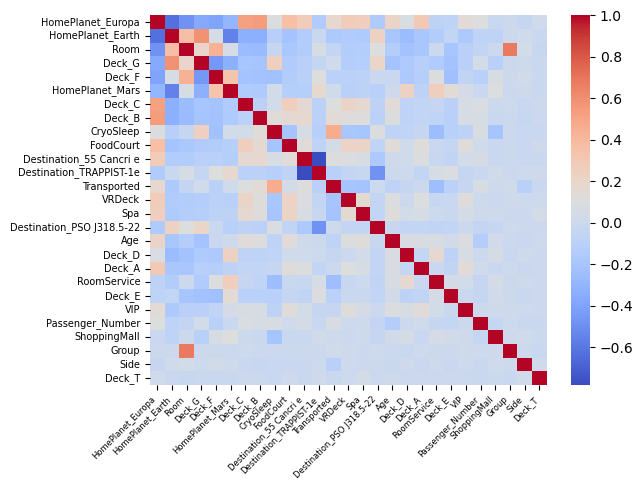

In [10]:
correlation = processed_df.corr()

sorted_indices = correlation.abs().mean().sort_values(ascending=False).index  # Sort by average absolute correlation
sorted_correlation = correlation.loc[sorted_indices, sorted_indices]

ax = sns.heatmap(sorted_correlation, fmt=".2f", cmap="coolwarm")

# Display all attributes
ax.set_xticks(np.arange(len(sorted_correlation.columns)) + 0.5, minor=False)
ax.set_yticks(np.arange(len(sorted_correlation.index)) + 0.5, minor=False)

# # Assign proper labels to all ticks
ax.set_xticklabels(sorted_correlation.columns, fontsize=6, rotation=45, ha="right")  # Rotate x-axis labels
ax.set_yticklabels(sorted_correlation.index, fontsize=7)

This graph shows that there are negative correlations between the home planets (which is obvious - if you're from one planet, you can't also be from another), and there's also negative correlations between the destinations (which also makes sense). There's also a positive correlation between the room and the side of the ship, which could mean that a certain set of rooms were on one side vs. another.

We wanted to specifically see if there was a correlation between the passenger's home planet and what ammeneties they received on the spaceship (the idea was that if they spent more, maybe they were more likely to stay on the ship since they might've been prioritized for safety).

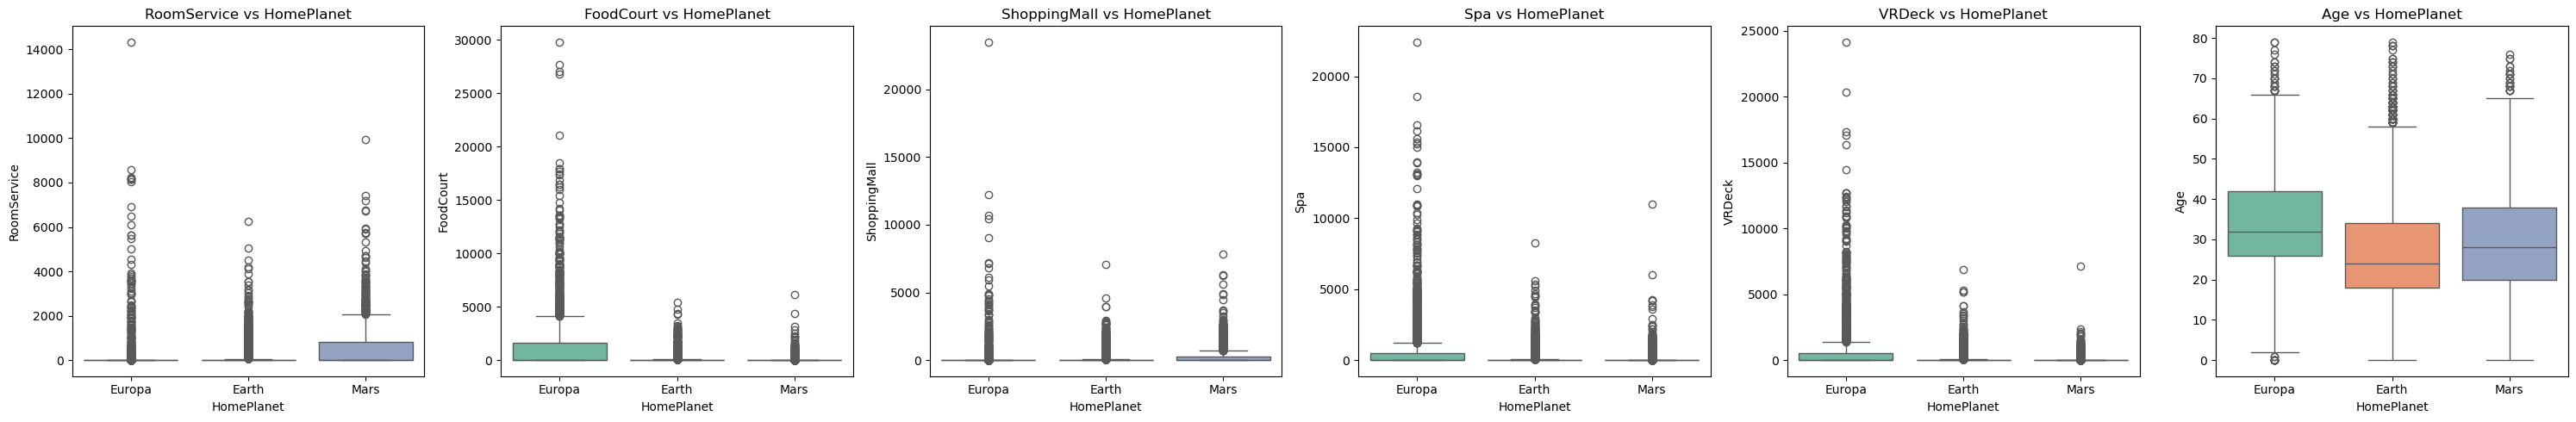

In [11]:
attributes = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Age"]
n_plots = len(attributes)

fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5), sharey=False)

for i, attribute in enumerate(attributes):
    sns.boxplot(
        data=imputed_df,
        x="HomePlanet",
        y=attribute,
        palette="Set2",
        ax=axes[i],
        hue="HomePlanet"
    )
    axes[i].set_title(f"{attribute} vs HomePlanet")
    axes[i].set_xlabel("HomePlanet")

plt.tight_layout()
plt.show()

There are a lot of outliers between all the home planets, but the general trend seems to be that the passengers from Europa tended to spend a lot on the spaceship's ammenities.

# Model Training

This is a function that prints out information about the best parameters for a certain model. 

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score

def fit_grid_search_cv(grid_search, features, labels_cv):
    
    x_train, x_test, y_train, y_test = train_test_split(features, labels_cv, test_size=0.2)

    grid_search.fit(x_train, y_train)

    print("Best parameters found: ", grid_search.best_params_)
    print("Best score found: ", grid_search.best_score_)
    print("Best estimator found: ", grid_search.best_estimator_)
    print("Best index found: ", grid_search.best_index_)

    best_model = grid_search.best_estimator_
    accuracy = cross_val_score(best_model, x_test, y_test, cv=5, scoring="accuracy").mean()
    print("Accuracy = " ,accuracy)
    return best_model


This is a function that prints out the classification report

In [13]:

from sklearn.metrics import confusion_matrix
def print_classification_statistics(best_model, processed_features, labels):
    label_preds = best_model.predict(processed_features)
    confusion_mat = confusion_matrix(labels, label_preds)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Prediced False', 'Predicted True'], yticklabels=['Acutal False', 'Actual True'])
    class_report = sklearn.metrics.classification_report(labels, label_preds)
    print(class_report)

### Decision Tree Model

- We Started off with training a decision tree classifier on the dataset. 
- Realizing we have 26 feature columns in our dataset, we decided to use PCA to reduce the dimensionality of the dataset.
- We created a pipeline with a PCA step and a decision tree classifier step which was then put into a grid search to find the best hyperparameters.

Best parameters found:  {'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__max_features': 20, 'clf__min_samples_leaf': 15, 'pca__n_components': 25}
Best score found:  0.7675675675675676
Best estimator found:  Pipeline(steps=[('pca', PCA(n_components=25)),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=15,
                                        max_features=20,
                                        min_samples_leaf=15))])
Best index found:  1544
Accuracy =  0.7257520162060925
              precision    recall  f1-score   support

       False       0.83      0.83      0.83      4019
        True       0.83      0.84      0.84      4075

    accuracy                           0.83      8094
   macro avg       0.83      0.83      0.83      8094
weighted avg       0.83      0.83      0.83      8094



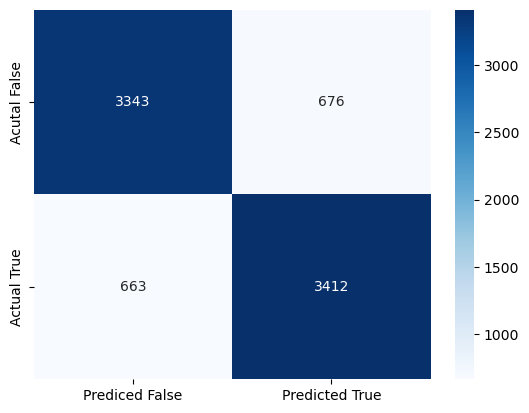

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline


clf = DecisionTreeClassifier()

# create a pipeline that first runs PCA and then the DecisionTreeClassifier
pipe = Pipeline(steps=[('pca', PCA()), ('clf', clf)])

param_grid = {
    "pca__n_components": [5, 10, 15, 20, 25],
    'clf__max_depth': [5, 10, 15, 20, 25, 30],
    'clf__min_samples_leaf': [5, 10, 15, 20, 25, 30],
    'clf__max_features': [5, 10, 15, 20, 25, 30],
    'clf__criterion': ['gini', 'entropy']
}

# runs the nested cross validation
# acc = cross_val_score(GridSearchCV(pipe, param_grid, cv=5), X=processed_features, y=labels, cv=10)
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

best_model = fit_grid_search_cv(grid_search, processed_features, labels)
print_classification_statistics(best_model, processed_features, labels)



- We found the best PCA components to be 20. 
- The best hyperparameters for the decision tree classifier were:
    - criterion: 'gini'
    - max_depth: 15
    - min_samples_leaf: 20
    - max_features: 15
    - splitter: 'best'

- After Splitting the dataset into a training and testing set (80-20 split), we trained the model on the training set and tested it on the testing set.
- The best score of the model while training was found to be 76.5% and the cross validation accuracy on the testing set was found to be 71.9%.

### KNN

- Next, we trained a KNN classifier on the dataset.
- We created a pipeline with a Standard Scaler Step, a PCA step and a KNN classifier step which was then put into a grid search to find the best hyperparameters.

Best parameters found:  {'knn__algorithm': 'auto', 'knn__n_neighbors': 14, 'knn__weights': 'distance', 'pca__n_components': 21}
Best score found:  0.7796138996138996
Best estimator found:  Pipeline(steps=[('std_scaler', StandardScaler()), ('pca', PCA(n_components=21)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=14, weights='distance'))])
Best index found:  192
Accuracy =  0.7523105148492146
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      4019
        True       0.97      0.95      0.96      4075

    accuracy                           0.96      8094
   macro avg       0.96      0.96      0.96      8094
weighted avg       0.96      0.96      0.96      8094



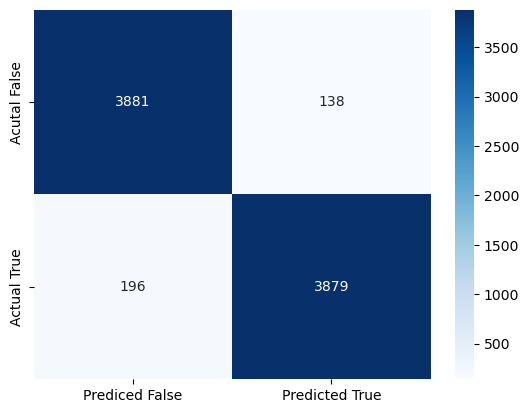

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier


std_scaler = StandardScaler()
pca = PCA()
knn = KNeighborsClassifier()

pipeline = Pipeline([
    ('std_scaler', std_scaler),
    ('pca', pca),
    ('knn', knn),
])

param_grid = {
    'pca__n_components': list(range(18, 25)),
    'knn__n_neighbors': list(range(1, 15)), 
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

inner_cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

best_model = fit_grid_search_cv(inner_cv, processed_features, labels)

print_classification_statistics(best_model, processed_features, labels)

- We found the best PCA components to be 21.
- The best hyperparameters for the KNN classifier were:
    - n_neighbors: 14
    - weights: 'distance'
    - algorithm: 'auto'

The best score while finding the best model was around 77%, and accuracy with the test data is 74%. 

### Support Vector Machine

We're going to now train a support vector model. 

Best parameters found:  {'pca__n_components': 18, 'svc__kernel': 'rbf'}
Best score found:  0.7882625482625483
Best estimator found:  Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=18)),
                ('svc', SVC())])
Best index found:  40
Accuracy =  0.7825650728127508
              precision    recall  f1-score   support

       False       0.77      0.84      0.80      4019
        True       0.83      0.76      0.79      4075

    accuracy                           0.80      8094
   macro avg       0.80      0.80      0.80      8094
weighted avg       0.80      0.80      0.80      8094



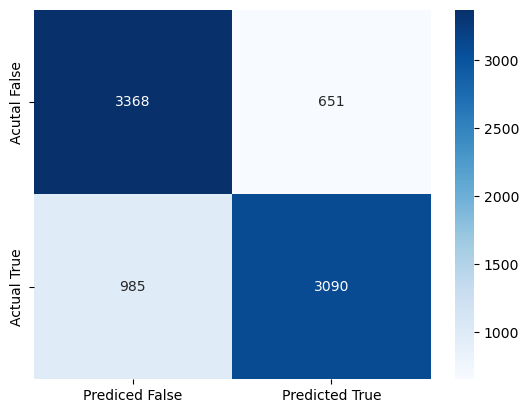

In [16]:
from sklearn.svm import SVC
import sklearn as sk

ss = StandardScaler()

pipeline = Pipeline([
    ('scaler', ss),
    ('pca', pca),
    ('svc', SVC())
])

params_grid = {
    'pca__n_components': list(range(5, 19)),
    'svc__kernel': ['linear', 'rbf', 'poly']
}

inner_cv = GridSearchCV(pipeline, params_grid, cv=5, scoring='accuracy', n_jobs=-1)
best_model = fit_grid_search_cv(inner_cv, processed_features, labels)
print_classification_statistics(best_model, processed_features, labels)

For SVM, the best trained model got around 78% accuracy, and with that model, we got around 77% accuracy when using the test dataset.

### Neural Network

Next, we're going to build a neural network using Tensorflow

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5232 - loss: 11.3846
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6791 - loss: 0.7035
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7260 - loss: 0.5537
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7596 - loss: 0.4980
Epoch 5/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7502 - loss: 0.5046
Epoch 6/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7625 - loss: 0.4757
Epoch 7/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7638 - loss: 0.4721
Epoch 8/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7765 - loss: 0.4469
Epoch 9/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7828 - loss: 0.4404
Epoch 10/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7815 - loss: 0.4461
Epoch 11/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7792 - loss: 0.4429
Epoch 12/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/st

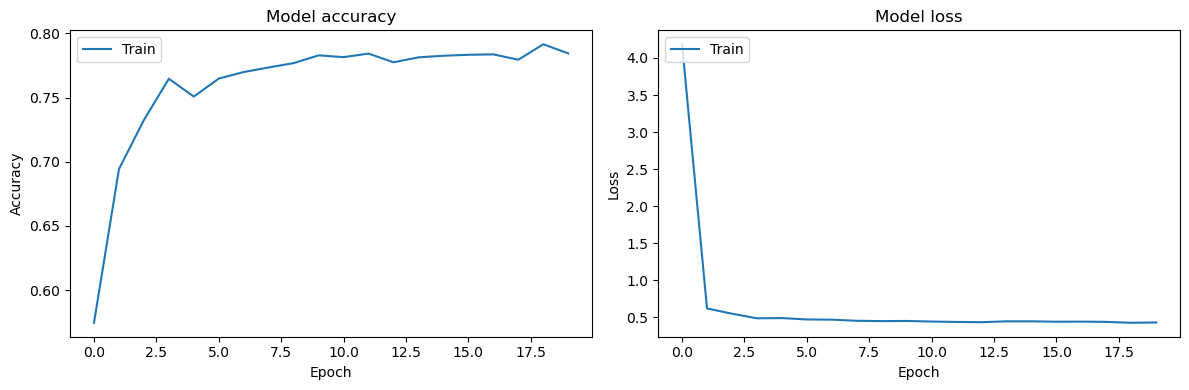

Accuracy:  0.7813465101914763


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

       False       0.50      1.00      0.66      4019
        True       0.56      0.00      0.01      4075

    accuracy                           0.50      8094
   macro avg       0.53      0.50      0.34      8094
weighted avg       0.53      0.50      0.33      8094



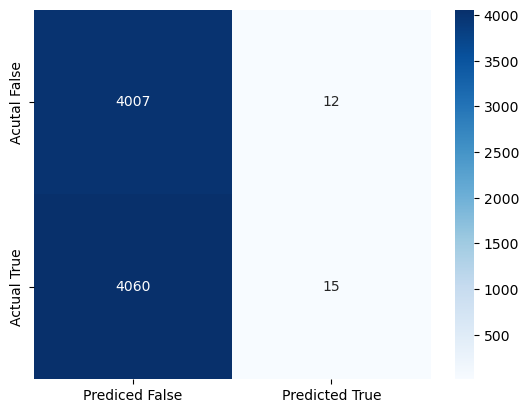

In [17]:
# Necessary Imports
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy

def plot_history(history):
    """
    Plots the training and validation loss and accuracy of a neural network model

    :param history: the history object of a trained model

    :return: None 
    """
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Train Model
X_train, X_test, y_train, y_test = train_test_split(pca_df, labels, test_size=0.2)

model = Sequential([
    Dense(2048, activation='relu', input_dim=X_train.shape[1]),
    Dense(2048, activation='relu'),
    Dropout(0.2),
    # Output layer for binary classification
    Dense(1, activation='sigmoid')  
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

y_pred = (model.predict(X_test) > 0.5).astype(int)

plot_history(history)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

print_classification_statistics(best_model, pca_df, labels)

With the neural network, we have achieved 80% accuracy with the test dataset. 

# Random Forest

- We trained a Random Forest classifier on the dataset. Due to the large number of features, we decided to use PCA to reduce the dimensionality of the dataset.
- We chose to test the accuracy of the random forest classifier due to its ability to fit itself to the data and its ability to handle large datasets. Due to its ensemble nature, it is also able to handle overfitting better than a decision tree. We were worried about overfitting due to noticing high accuracy results in our decision tree and KNN models in the training set but lower accuracy in the testing set.
- The above assumption was reinforced when we saw an increase in accuracy when we increased the number of trees in the random forest classifier.

Best parameters found:  {'pca__n_components': 10, 'rf__max_depth': 15, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 30, 'rf__n_estimators': 250}
Best score found:  0.7958301158301159
Best estimator found:  Pipeline(steps=[('pca', PCA(n_components=10)),
                ('rf',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=5,
                                        min_samples_split=30,
                                        n_estimators=250))])
Best index found:  17
Accuracy =  0.7708443221343118
              precision    recall  f1-score   support

       False       0.86      0.85      0.85      4019
        True       0.85      0.87      0.86      4075

    accuracy                           0.86      8094
   macro avg       0.86      0.86      0.86      8094
weighted avg       0.86      0.86      0.86      8094



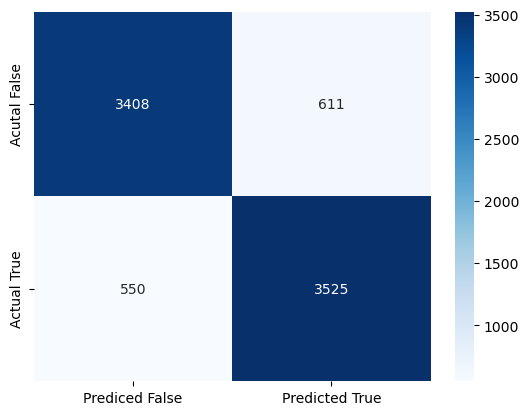

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

pca = PCA()
rf = RandomForestClassifier()

pipeline = Pipeline([
    ('pca', pca),
    ('rf', rf),
])

param_grid = {
    'pca__n_components': list(range(10, 25, 50)),
    'rf__n_estimators': list(range(100, 450, 50)),
    'rf__max_depth': list(range(15, 20, 5)),
    'rf__min_samples_split': list(range(10, 50, 10)),
    'rf__min_samples_leaf': list(range(5, 15, 5)),
}

inner_cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
best_model = fit_grid_search_cv(inner_cv, processed_features, labels)
print_classification_statistics(best_model, processed_features, labels)

- We found the best PCA components to be 10
- The best hyperparameters for the random forest classifier were:
    - n_estimators: 150
    - criterion: 'gini'
    - max_depth: 15
    - min_samples_leaf: 5
    - min_aamples_split: 10

### KMeans Clustering

- Reasoning and results description:
- Cluster 0: Predominantly non-transported passengers
- Cluster 1: Primarily non-transported passengers
- Low accuracy suggests the clustering does not perfectly align with the transport status.
- KMeans captures general groupings, but it doesn’t fully capture transport status, indicating other features may be influencing the clustering.
- KMeans is useful for identifying general patterns but may not be ideal for directly predicting the transport status in this case.

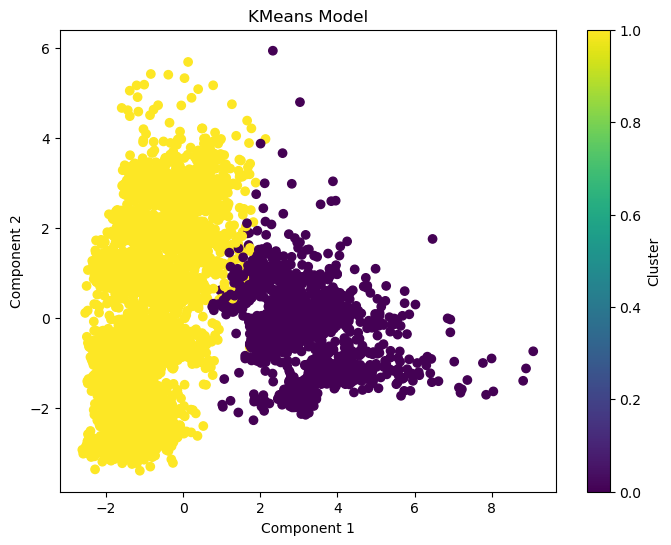

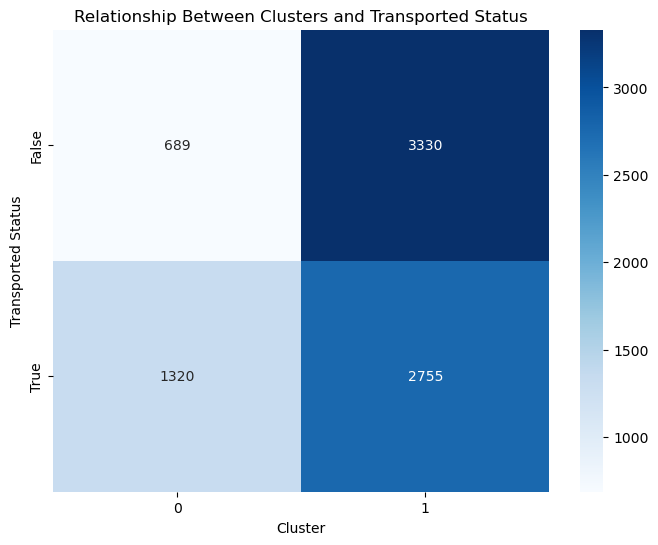

Clustering accuracy: 0.43
Cluster Mapping: {0: 'Transported', 1: 'Not Transported'}


In [19]:
from sklearn.cluster import KMeans

# Remove 'Transported' from the features for clustering
features = processed_df.drop(labels="Transported", axis="columns")

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# KMeans with 2 clusters and ensure random state
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(features_scaled)

# Assign the cluster labels
processed_df['Cluster'] = kmeans.labels_
pca = PCA(n_components=2)
pca_data = pca.fit_transform(features_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=processed_df['Cluster'], cmap='viridis')
plt.title("KMeans Model")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Create a contingency table
contingency_table = pd.crosstab(processed_df['Transported'], processed_df['Cluster'])

plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap="Blues", fmt='d')
plt.title("Relationship Between Clusters and Transported Status")
plt.xlabel("Cluster")
plt.ylabel("Transported Status")
plt.show()

# Accuracy Calculation
total_correct = contingency_table.iloc[0, 0] + contingency_table.iloc[1, 1]
total_samples = contingency_table.values.sum()
accuracy = total_correct / total_samples
print(f"Clustering accuracy: {accuracy:.2f}")

# Determine which cluster represents 'Transported' or 'Not Transported'
cluster_mapping = {}
if contingency_table.iloc[0, 0] > contingency_table.iloc[1, 0]:
    cluster_mapping[0] = "Not Transported"
    cluster_mapping[1] = "Transported"
else:
    cluster_mapping[0] = "Transported"
    cluster_mapping[1] = "Not Transported"


print(f"Cluster Mapping: {cluster_mapping}")

K-Means clustering is the worst performing models, as it's only 42% accurate. 

Based on all of our models, the best performing model is our neural network. We can now use this neural network to predict whether passengers in the actual test dataset have been transported or not. We're first going to apply the same transformations that we did to the training data to the test data.

In [20]:
test_df = pd.read_csv("test.csv")
test_df["HomePlanet"] = test_df["HomePlanet"].fillna(test_df["HomePlanet"].apply(lambda _: np.random.choice(value_counts.index, p=value_counts.values)))

# fill NaNs in Destination with random values based on distribution
value_counts = imputed_df['Destination'].value_counts(normalize=True)
test_df["Destination"] = test_df["Destination"].fillna(test_df["Destination"].apply(lambda _: np.random.choice(value_counts.index, p=value_counts.values)))

# Impute RoomService with the median
test_df["RoomService"] = test_df["RoomService"].fillna(test_df["RoomService"].median())

# Impute FoodCourt with the median
test_df["FoodCourt"] = test_df["FoodCourt"].fillna(test_df["FoodCourt"].median())

# Impute ShoppingMall with the median
test_df["ShoppingMall"] = test_df["ShoppingMall"].fillna(test_df["ShoppingMall"].median())

# Impute Spa with the median
test_df["Spa"] = test_df["Spa"].fillna(test_df["Spa"].median())

# Impute VRDeck with the median
test_df["VRDeck"] = test_df["VRDeck"].fillna(test_df["VRDeck"].median())

# Impute Age with the mean
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())

# drop NaNs
test_df = test_df.dropna()
# Drop Name values since they're nearly unique for each passenger and not useful for prediction
test_df = test_df.drop(columns=['Name'])

test_df[["Deck", "Room", "Side"]] = test_df['Cabin'].str.split("/", expand=True)
test_df = test_df.drop(columns=['Cabin'])
test_df
# Split Passenger values into two columns
test_df[["Group", "Passenger_Number"]] = test_df['PassengerId'].str.split("_", expand=True)
passengers = test_df['PassengerId']
test_df = test_df.drop(columns=['PassengerId'])

# One hot encode the HomePlanet
test_df = pd.get_dummies(test_df, columns=["HomePlanet"])

# One hot encode the DestinationPlanet
test_df = pd.get_dummies(test_df, columns=["Destination"])

# One hot encode the Deck
test_df = pd.get_dummies(test_df, columns=["Deck"])

# convert Side to T or F
test_df["Side"] = test_df['Side'].map({'P': True, 'S' : False})

# normalizing numeric features
scaler = StandardScaler()
test_df['RoomService'] = scaler.fit_transform(test_df[['RoomService']])
test_df['FoodCourt'] = scaler.fit_transform(test_df[['FoodCourt']])
test_df['ShoppingMall'] = scaler.fit_transform(test_df[['ShoppingMall']])
test_df['Spa'] = scaler.fit_transform(test_df[['Spa']])
test_df['VRDeck'] = scaler.fit_transform(test_df[['VRDeck']])
test_df['Age'] = scaler.fit_transform(test_df[['Age']])
test_df['Group'] = scaler.fit_transform(test_df[['Group']])
test_df['Passenger_Number'] = scaler.fit_transform(test_df[['Passenger_Number']])

pca_test_arr = PCA(n_components=26).fit_transform(test_df)
pca_test_arr.shape

# Predict the clusters of the test data
preds = model.predict(pca_test_arr)
preds = (preds > 0.5).astype(int)
i = 0
for passenger in passengers:
    print(f"Passenger {passenger} is {'Transported' if preds[i] == 1 else 'Not Transported'}")
    i += 1

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Passenger 0013_01 is Not Transported
Passenger 0018_01 is Not Transported
Passenger 0019_01 is Transported
Passenger 0021_01 is Transported
Passenger 0023_01 is Not Transported
Passenger 0027_01 is Not Transported
Passenger 0029_01 is Transported
Passenger 0032_01 is Transported
Passenger 0032_02 is Transported
Passenger 0033_01 is Not Transported
Passenger 0037_01 is Not Transported
Passenger 0040_01 is Not Transported
Passenger 0040_02 is Transported
Passenger 0042_01 is Transported
Passenger 0046_01 is Not Transported
Passenger 0046_02 is Not Transported
Passenger 0046_03 is Not Transported
Passenger 0047_01 is Transported
Passenger 0048_01 is Not Transported
Passenger 0049_01 is Not Transported
Passenger 0054_01 is Transported
Passenger 0054_02 is Transported
Passenger 0054_03 is Transported
Passenger 0055_01 is Not Transported
Passenger 0057_01 is Transported
Passenger 0059_01 is Transported
Passenger 0060_01 is Not Transported
Passenger 00